# SCimilarity search using centroids and clusters

The goal of this tutorial is to demonstrate a more flexible method for cell search, using centroids. Much of the early steps will be identical to *cell_search_tutorial_1.ipynb* and thus the explanations for those steps will be reduced for the sake of brevity. We will again use the [Adams et al. 2020](https://www.science.org/doi/10.1126/sciadv.aba1983?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) healthy and IPF lung scRNA-seq data.

An important thing to note is that the cells inputed into the query are what determine the query results. The average of a scattered collection of cells will not bring meaningful results. There are some built-in QC stats with which you can evaluate the centroid quality and we will demonstrate them in this tutorial.

#### There will be three analyses shown for querying cells:
 1. Perform cell search on a regulatory T cell centroid.
 
 2. Perform cell search on a T cell centroid.

 3. Perform cell search on a macrophage centroid.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Environment settings
import scanpy as sc
from matplotlib import pyplot as plt

sc.set_figure_params(dpi=100)
plt.rcParams['figure.figsize'] = [6, 4] 
plt.rcParams['figure.autolayout'] = True

import warnings
warnings.filterwarnings('ignore')

/home/kuot/miniconda3/envs/gpy/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## 1. Prepare for SCimilarity: Import and normalize data

In [3]:
from scimilarity.utils import lognorm_counts, align_dataset
from scimilarity import CellQuery

In [4]:
## TODO
## RESTRUCTURE THE MODEL PATHS FOR DOWNLOAD FILES

# If the models haven't been downloaded please uncomment and run the two command below
#!curl -L -o /models/query_model_v1.tar.gz https://zenodo.org/record/8240464/files/query_model_v1.tar.gz?download=1
#!tar -xzvf /models/query_model_v1.tar.gz

In [5]:
# Instantiate the CellQuery object.
# Replace model_path with your local file path.
from scimilarity import ModelPath
model_path = ModelPath.model_paper
cq = CellQuery(model_path)

### Load scRNA-seq data

In [6]:
# To Download the demo data to the data/ directory uncomment and run the command below
#! curl -L -o "{download_dir}/GSE136831_subsample.h5ad" https://zenodo.org/record/8242083/files/GSE136831_subsample.h5ad?download=1

In [7]:
# Load the tutorial data.
# Replace data_path with your local file path.
data_path = '../data/GSE136831_subsample.h5ad'
adams = sc.read(data_path)

In [8]:
adams = align_dataset(adams, cq.gene_order)
adams = lognorm_counts(adams)

## 2. Compute embeddings
Using the already trained models, SCimilarity can embed your new dataset. 

In [9]:
adams.obsm['X_scimilarity'] = cq.get_embeddings(adams.X)

In [10]:
sc.pp.neighbors(adams, use_rep='X_scimilarity')
sc.tl.umap(adams)

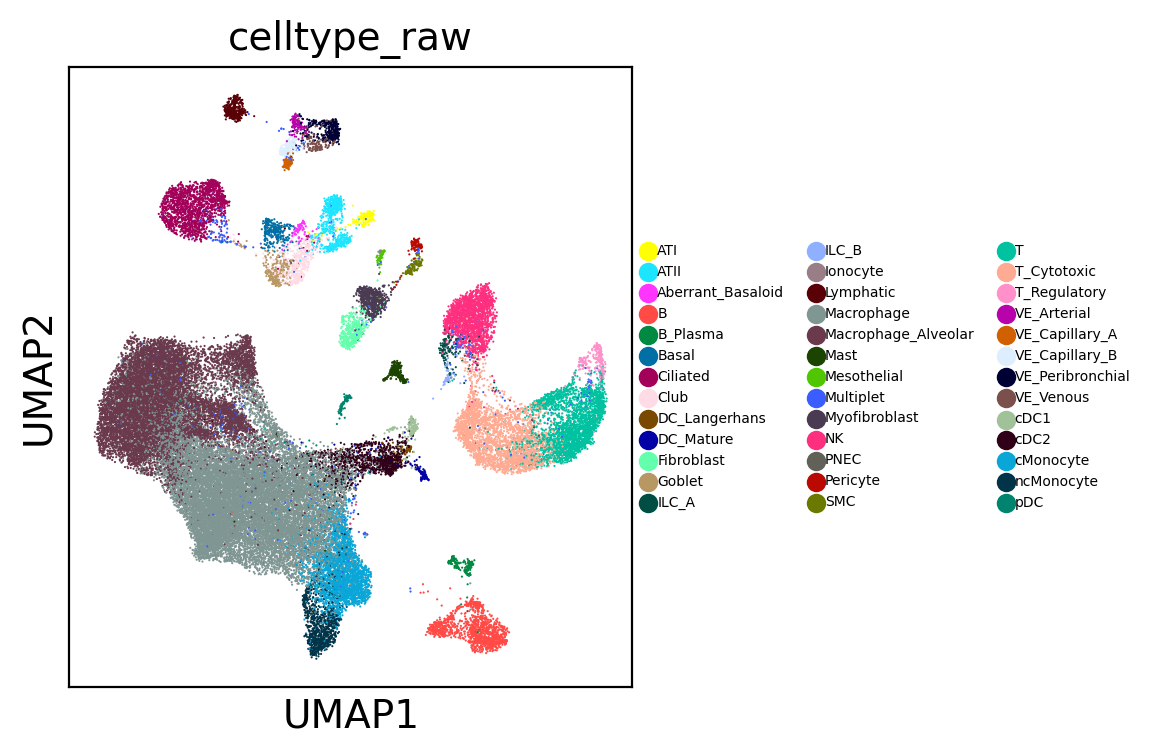

In [11]:
sc.pl.umap(adams, color='celltype_raw', legend_fontsize=5)

## 3. Identify query cell states

The more coherent and specific the cell population is the more interesting the results typically are. Cell subtypes/subclustering are usually more interesting.

In this example, we use celltype information to identify query cells though we can also use clusters.

In [12]:
cells_used_in_query = adams.obs['celltype_raw'] == 'T_Regulatory'
adams.obs['treg_query'] = cells_used_in_query.astype(int)

In [13]:
cells_used_in_query = adams.obs['celltype_raw'] == 'T'
adams.obs['t_query'] = cells_used_in_query.astype(int)

In [14]:
cells_used_in_query = adams.obs['celltype_raw'] == 'Macrophage'
adams.obs['macrophage_query'] = cells_used_in_query.astype(int)

In [15]:
cells_used_in_query = (adams.obs['celltype_raw'] == 'T_Regulatory') | (adams.obs['celltype_raw'] == 'T_Cytotoxic')
adams.obs['treg_tcyto_query'] = cells_used_in_query.astype(int)

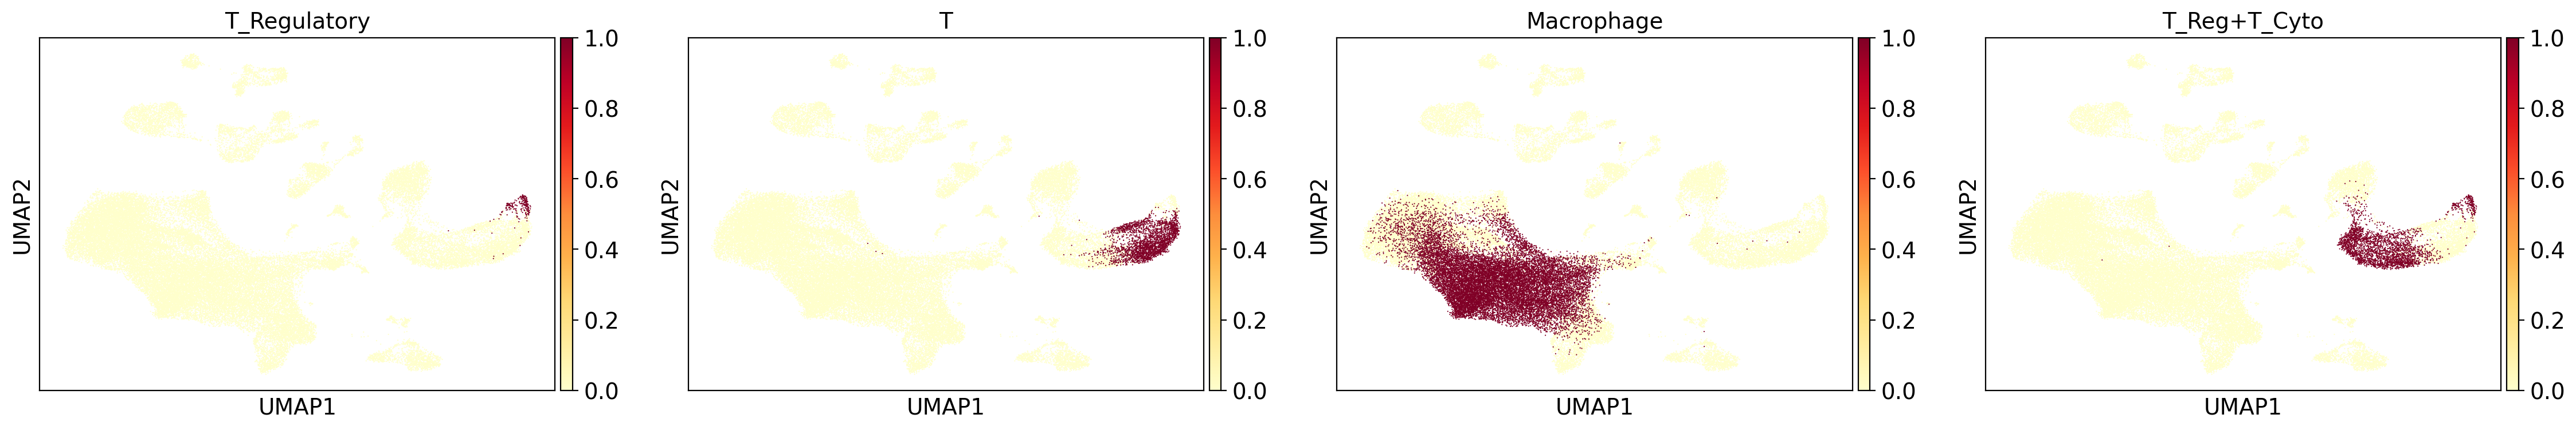

In [16]:
sc.pl.umap(adams, color=['treg_query', 't_query', 'macrophage_query', 'treg_tcyto_query'], title=['T_Regulatory', 'T', 'Macrophage', 'T_Reg+T_Cyto'], cmap='YlOrRd')

### Perform cell search on centroid
The centroid search method provides a QC output with which you can evaluate the quality of the centroid and search results.

QC stats:
  - centroid_intradistance: Mean distance of cells that comprise the centroid to the centroid.
  - centroid_enrichment: Enrichment of cells that comprise the centroid versus non-centroid cells.
  - centroid_pval: The p-value of the centroid being comprised of non-centroid cells.
  - query_enrichment: The consistency of query results between the centroid and cells that comprise the centroid.

  - 10 centroids, stability 
  - query stability score, cells versus centroids

  - confidence ellipis

For more details, see the Section## in the paper.

In [17]:
centroid_embedding, nn_idxs, nn_dists, treg_metadata, qc_stats = cq.search_centroid(adams, 'treg_query')
print(qc_stats)

{'centroid_stability': 0.6748727187893157, 'query_stability': 29.3}


In [18]:
centroid_embedding, nn_idxs, nn_dists, t_metadata, qc_stats = cq.search_centroid(adams, 't_query')
print(qc_stats)

{'centroid_stability': 0.6915503572858615, 'query_stability': 11.3}


In [19]:
centroid_embedding, nn_idxs, nn_dists, macrophage_metadata, qc_stats = cq.search_centroid(adams, 'macrophage_query')
print(qc_stats)

{'centroid_stability': 0.5346187208645143, 'query_stability': 2.1}


In [20]:
centroid_embedding, nn_idxs, nn_dists, treg_tcyto_metadata, qc_stats = cq.search_centroid(adams, 'treg_tcyto_query')
print(qc_stats)

{'centroid_stability': 0.5252000567838908, 'query_stability': 18.8}


In [21]:
def calculate_disease_proportions(metadata):
    study_proportions = metadata.disease.value_counts()
    return 100*study_proportions / study_proportions.sum()

def plot_proportions(df, title=None):
    ax = df.plot(kind='barh', 
            xlabel='percent of cells',
            title=title, 
            grid=False,
            figsize=(8,5))
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xticklabels([f'{int(tick)}%' for tick in ax.get_xticks()]);
    plt.tight_layout()

##### Exclude self-referencing results
Naturally, queries searching for similar cells will highlight cells from the same study. To get a clearer view of the results, we often exclude those self-referencing hits.

In [ ]:
query_study = 'DS000011735'
filtered_result_metadata = treg_metadata[treg_metadata.study!=query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
plot_proportions(query_disease_frequencies, title='disease proportions for most similar cells')

In [ ]:
query_study = 'DS000011735'
filtered_result_metadata = t_metadata[t_metadata.study!=query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
plot_proportions(query_disease_frequencies, title='disease proportions for most similar cells')

In [ ]:
# Filtering out the query study filtered out all cells as it did not retrieve any cells outside the query study
# Potentially this is due to the lack of good centroid quality

query_study = 'DS000011735'
filtered_result_metadata = macrophage_metadata[macrophage_metadata.study!=query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
plot_proportions(query_disease_frequencies, title='disease proportions for most similar cells')

In [ ]:
macrophage_metadata